In [1]:
from collections import defaultdict
import copy
import csv
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import convolve
from scipy.special import gamma
from scipy.stats import poisson
%matplotlib inline

# Experimental images

## Create `experimental_images` dictionary containing experimental data.

First, read the legend file with the list of files and metadata from the experiment.

In [2]:
folder_name = "data_files"
legend_filename = "_legend.csv"
file_extension = ".h5"

with open(f'{folder_name}/{legend_filename}') as f:
    reader = csv.reader(f)
    legend = list(reader)

file_list = [
    { 'name': row[0], 'exposure_time_in_ms': float(row[1]), 'with_ion': row[2].upper() == 'Y' }
    for row in legend[1:]]

Next, read all the images and store them in the `experimental_images` dictionary.

In [3]:
raw_experimental_images = { 'bright': defaultdict(list), 'dark': defaultdict(list) }

for file in file_list:
    ion_state = 'bright' if file['with_ion'] else 'dark'
    exposure_time_in_ms = file['exposure_time_in_ms']
    with h5py.File(f"{folder_name}/{file['name']}{file_extension}", 'r') as f:
        for datapoint_idx in range(1,10):
            try:
                datapoint = f["images"][f"datapoint{datapoint_idx}"]
            except:
                continue

            for image_idx in range(100):
                image_data = datapoint[str(image_idx)][()] * 2.438 / 1e8  # scaling to make data easier to work with
                raw_experimental_images[ion_state][exposure_time_in_ms].append(image_data)

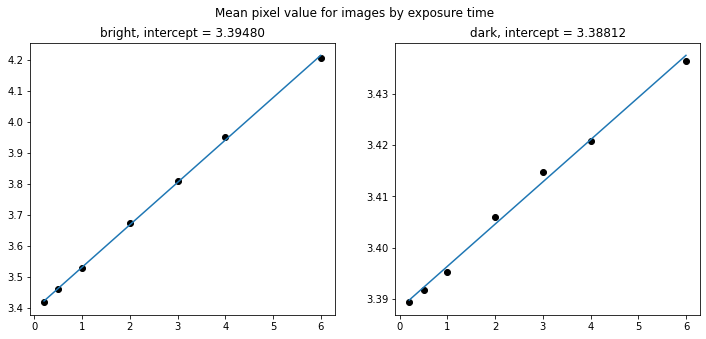

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for i, ion_state in enumerate(['bright', 'dark']):
    exposure_times = [0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 6.0]
    mean_value = [np.mean(raw_experimental_images[ion_state][t]) for t in exposure_times]
    axes[i].plot(exposure_times, mean_value, 'ko')
    
    m, b = np.polyfit(exposure_times, mean_value, 1)
    axes[i].plot(exposure_times, np.multiply(m, exposure_times) + b)
    
    axes[i].set_title(f'{ion_state}, intercept = {b:.5f}')

plt.suptitle(f'Mean pixel value for images by exposure time')
plt.show()

In [5]:
# subtract the y-intercept from the data so that "zero" is meaningful
experimental_images = {
    'bright': { k: np.subtract(v, 3.39480) for k,v in raw_experimental_images['bright'].items() },
    'dark': { k: np.subtract(v, 3.38812) for k,v in raw_experimental_images['dark'].items() }
}

To see what the data looks like, plot the mean bright and dark images for each exposure time.

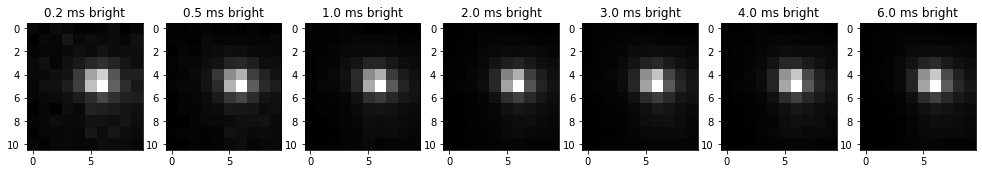

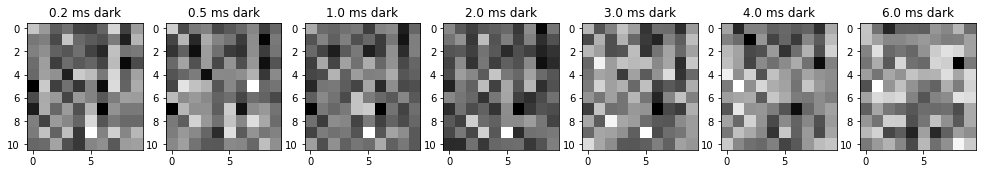

In [6]:
for ion_state in ['bright', 'dark']:
    fig, axes = plt.subplots(nrows=1, ncols=len(experimental_images[ion_state]), figsize=(17,4))
    for i, exposure_time_in_ms in enumerate(sorted(experimental_images[ion_state])):
        avg_image = np.mean(experimental_images[ion_state][exposure_time_in_ms], 0)
        axes[i].imshow(avg_image, cmap=plt.get_cmap('gray'))
        axes[i].set_title(f'{exposure_time_in_ms} ms {ion_state}')

## Fit a Poisson distribution to each pixel.

failed to fit for row 0, col 1, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 0.2. assuming lambda = 0.
failed to fit for row 2, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 2, col 2, t_exp 0.2. assuming lambda = 0.
failed to fit for row 3, col 2, t_exp 0.2. assuming lambda = 0.
failed to fit for row 5, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 6, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 7, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 7, col 2, t_exp 0.2. assuming lambda = 0.
failed to fit for row 8, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 9, col 0, t_exp 0.

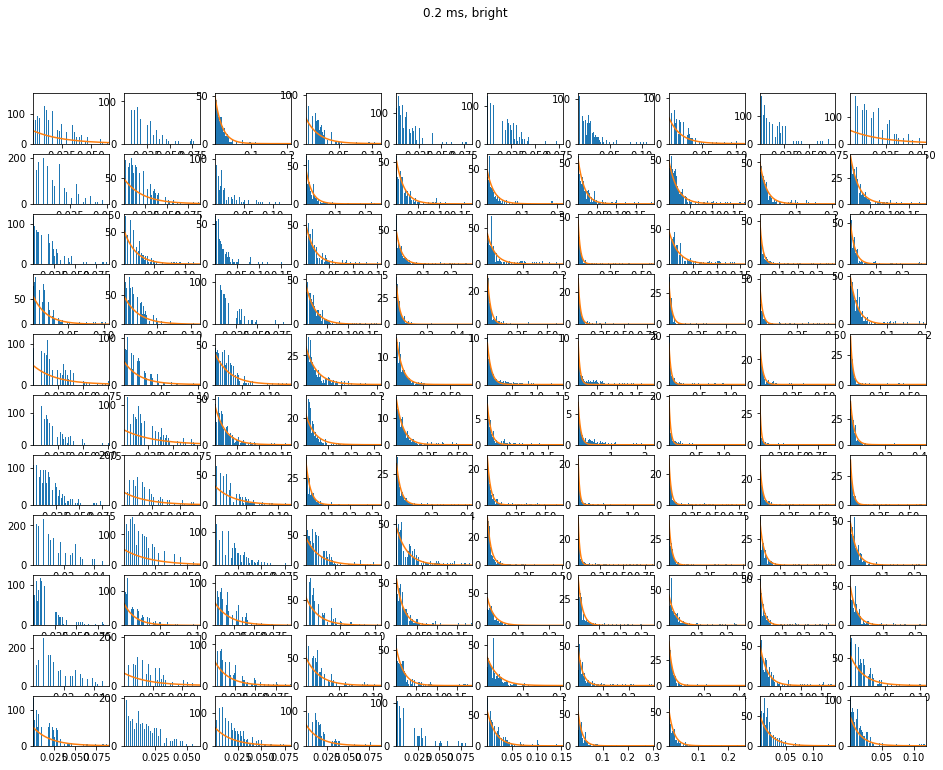

failed to fit for row 0, col 8, t_exp 0.5. assuming lambda = 0.
failed to fit for row 8, col 1, t_exp 0.5. assuming lambda = 0.


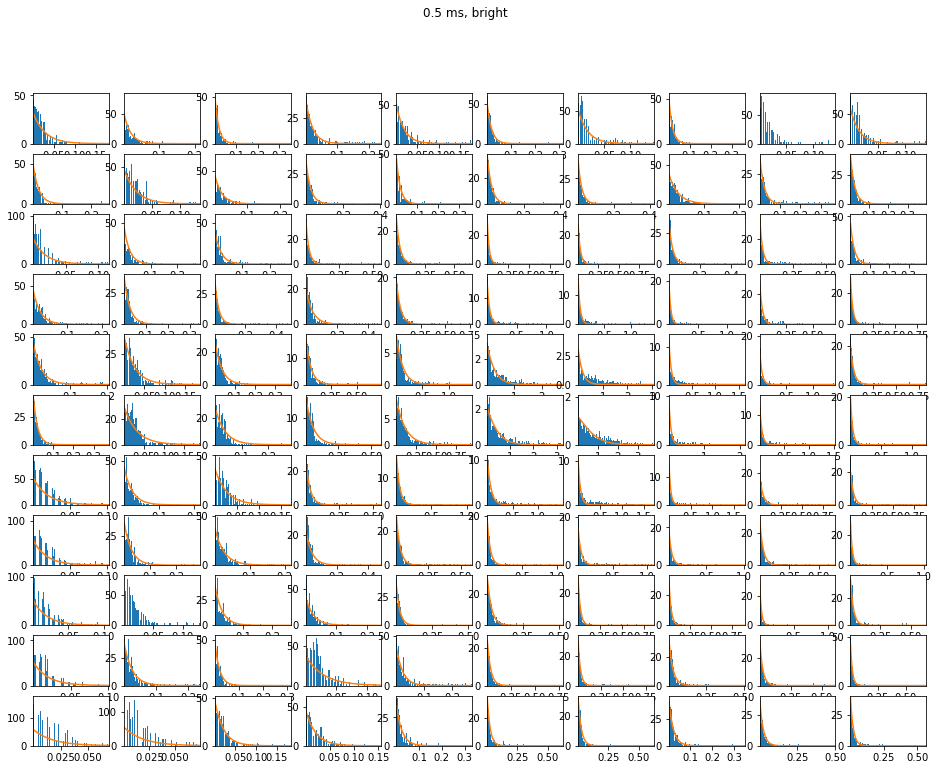

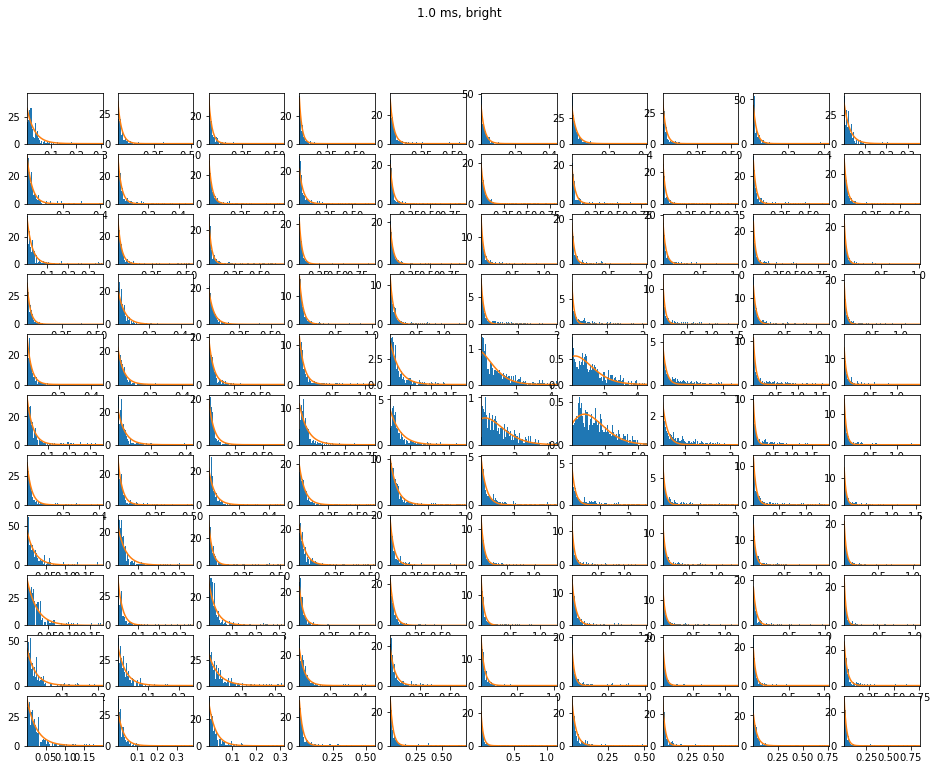

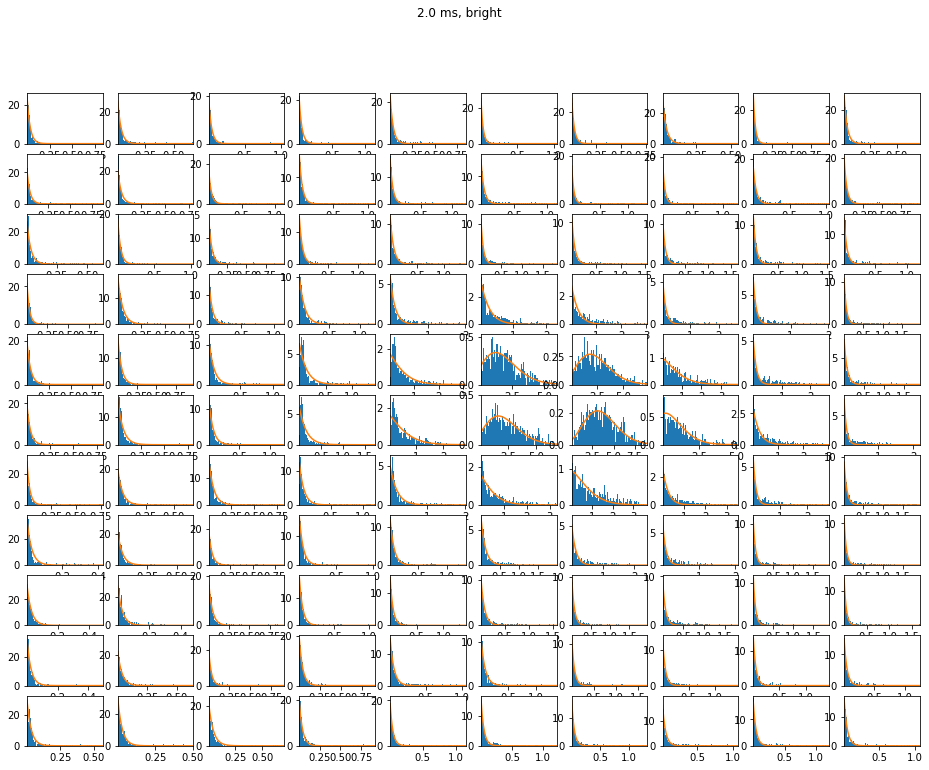

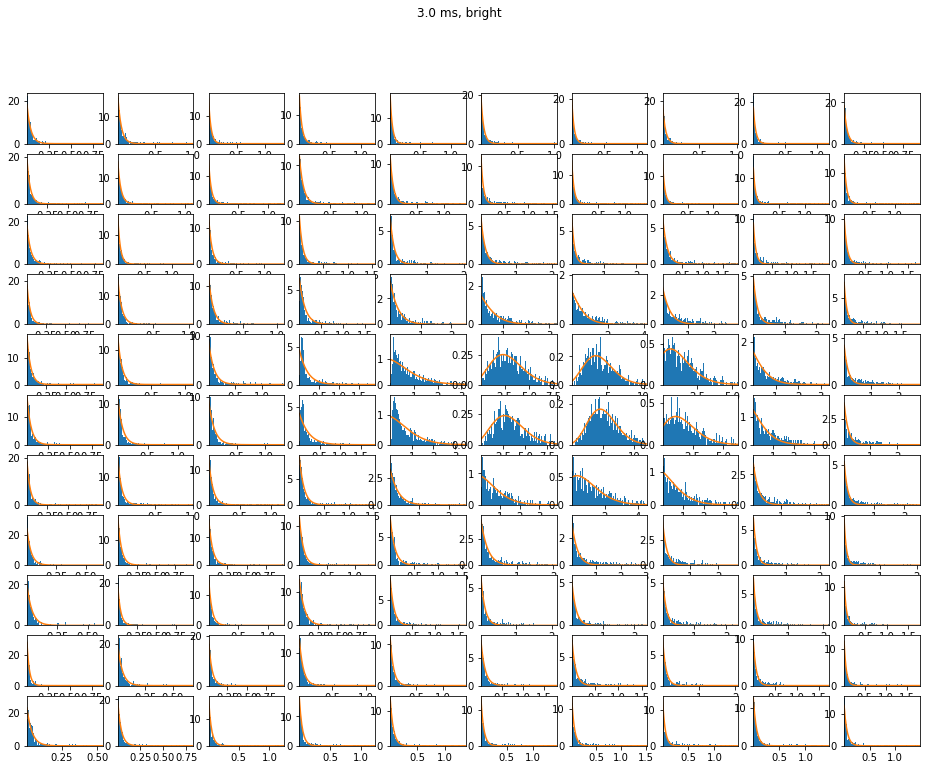

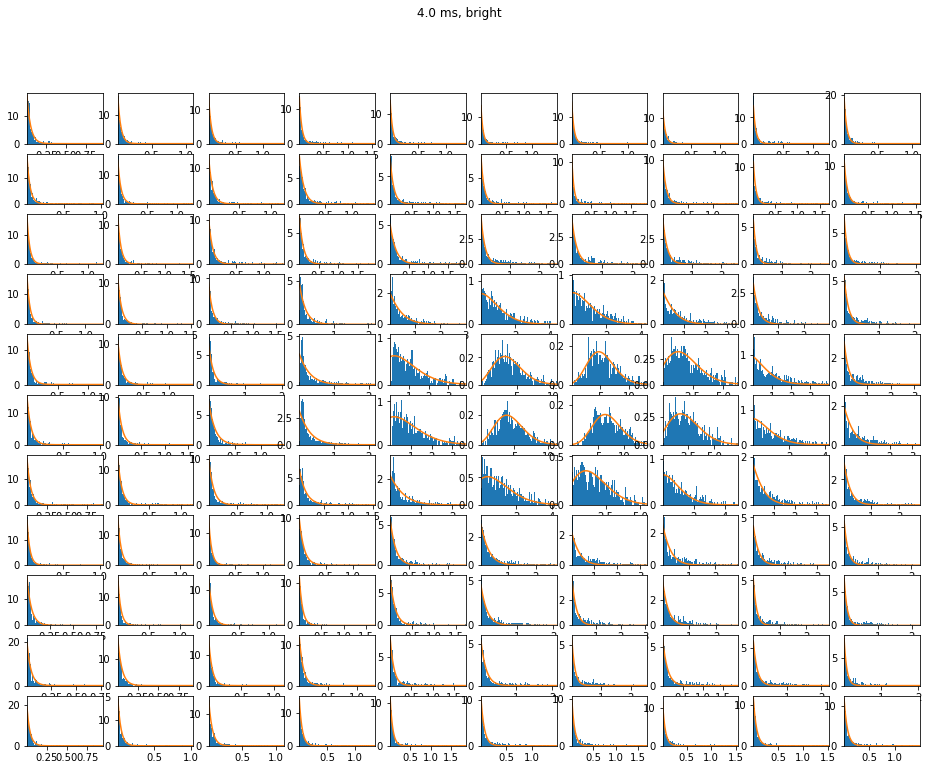

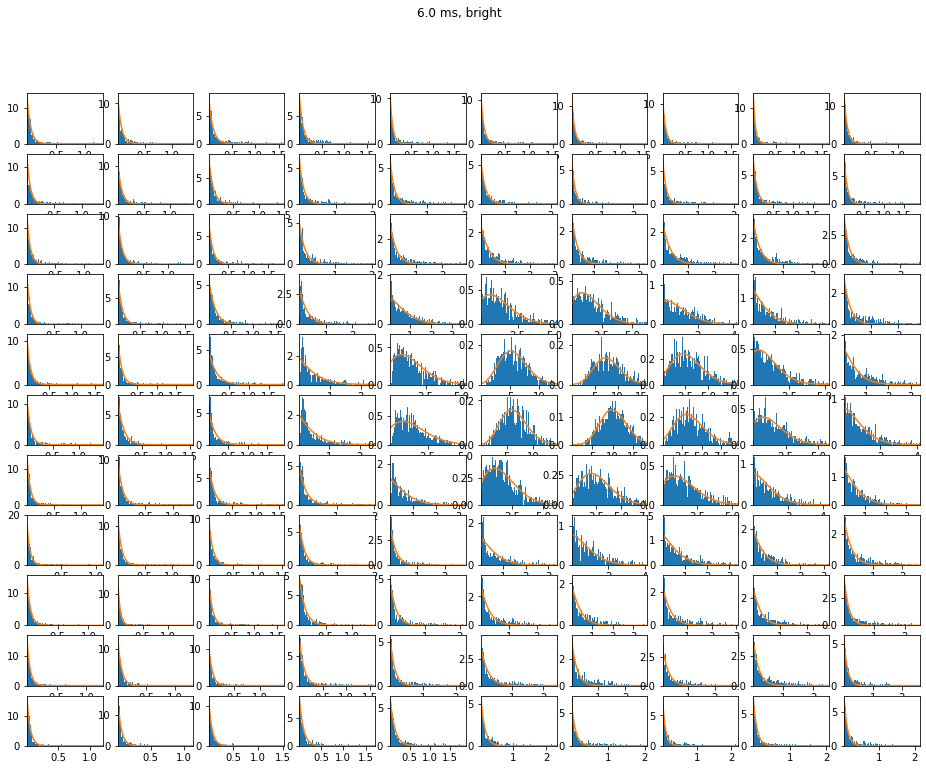

In [7]:
lambda_bright = defaultdict(list)

ion_state = 'bright'

exposure_times = [0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 6.0]
for exposure_time in exposure_times:
    fig, axes = plt.subplots(nrows=11, ncols=10, figsize=(16,12))
    for row in range(0, 11):
        lambda_row = []
        for col in range(0, 10):
            axis = axes[row][col]
            one_pixel = [image[row][col] for image in experimental_images[ion_state][exposure_time]]
            histogram_range = (0, np.percentile(one_pixel, q=98) * 1.1)
            y,x,_ = axis.hist(np.array(one_pixel).ravel(), bins=128, range=histogram_range, density=True)
            x1 = [(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)]

            def poisson(x, A, lamb, b):
                '''A is amplitude, lamb is mean, b is horizontal scaling.'''
                bx = np.multiply(b, x)
                return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

            def scaled_poisson(x, A, lamb):
                return poisson(x, A, lamb, b=1.0)  # make the horizontal scaling constant

            guess = [5.0, np.mean(one_pixel)]
            if True:
                try:
                    popt, pcov = curve_fit(scaled_poisson, x1, y, p0=guess, bounds=((0, 0), (np.inf, np.inf)))
                    axis.plot(x1, scaled_poisson(x1, *popt))
                    lambda_row.append(popt[1])
                    #print(*popt)
                    #print(f'lambda={popt[1]} for row {row}, col {col}, t_exp {exposure_time}')
                except:
                    print(f'failed to fit for row {row}, col {col}, t_exp {exposure_time}. assuming lambda = 0.')
                    lambda_row.append(0)

            #x_fit = np.linspace(histogram_range[0], histogram_range[1], 8001)
            #axis.plot(x_fit, scaled_poisson(x_fit, *guess), 'k--', label='initial guess', lw=2)

            #axis.set_title(f'row {row}, col {col}')
            axis.set_xlim(min(x1), max(x1))

        lambda_bright[exposure_time].append(lambda_row)

    plt.suptitle(f'{exposure_time} ms, {ion_state}')
    plt.show()

## Plot the fitted $\lambda$ values for each pixel as a function of exposure time.

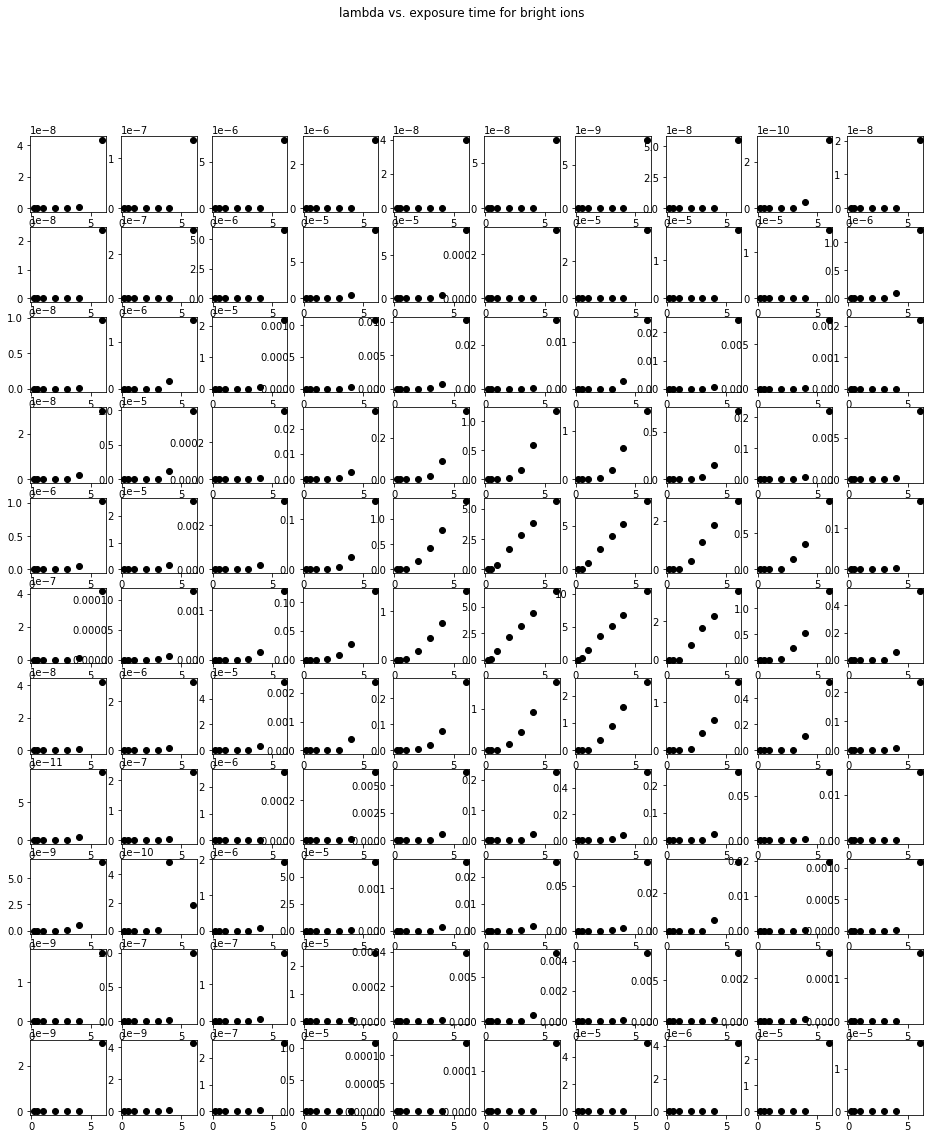

In [8]:
fig, axes = plt.subplots(nrows=11, ncols=10, figsize=(16,18))
for row in range(0, 11):
    for col in range(0, 10):
        axis = axes[row][col]
        lambda_values = [lambda_bright[t][row][col] for t in exposure_times]
        axis.plot(exposure_times, lambda_values, 'ko')
        #axis.set_title(f'row {row}, col {col}')

plt.suptitle(f'lambda vs. exposure time for bright ions')
plt.show()

# Artificial images

We want to generate artificial images that reliably reproduce the behavior of the real images as a function of exposure time.

In [202]:
def generate_artificial_image(exposure_time_in_ms, is_bright):
    
    # adjust this parameter so that the lambda scaling matches the experimental images
    photons_per_ms = 8
    
    # these parameters are from a 2-D Gaussian fit of the experimental images
    mean = [5.71, 4.61]
    cov = [[0.5364, -0.026], [-0.026, 0.7468]]
    
    # calculate the number of photons to be received by the camera
    expected_num_photons = photons_per_ms * exposure_time_in_ms if is_bright else 0
    num_photons = np.random.poisson(expected_num_photons)
    
    if is_bright:
        num_photons = max(1, num_photons)
    
    # generate the arrival coordinates for each photon
    x, y = np.random.multivariate_normal(mean, cov, num_photons).T

    # set up the image array
    img_h, img_w = 11, 10
    data = np.zeros((img_h, img_w), dtype=np.float)

    # find out which pixel each photon hit
    for i in range(len(x)):
        x_pixel = int(round(x[i]))
        y_pixel = int(round(y[i]))
        if x_pixel < 0 or x_pixel >= img_w or y_pixel < 0 or y_pixel >= img_h:
            continue

        data[y_pixel][x_pixel] += 1.0

    # each photon has a different impact on the pixel value due to excess noise
    # factor in the EMCCD gain. model this by drawing from a gamma distribution
    # with the number of photons as the mean.
    for y_pixel in range(img_h):
        for x_pixel in range(img_w):
            data[y_pixel][x_pixel] = np.random.gamma(data[y_pixel][x_pixel])
        
    # add readout noise
    data_without_emccd_noise = copy.deepcopy(data)
    for y_pixel in range(img_h):
        for x_pixel in range(img_w):
            # model charge-induced noise from EMCCD as a gamma distribution with
            # mean 0.1 per photon that hit any pixel in this row or column
            neighboring_photons = sum(
                [data_without_emccd_noise[y_pixel][x] / abs(x-x_pixel) for x in range(img_w) if x != x_pixel]
                + [data_without_emccd_noise[y][x_pixel] / abs(y-y_pixel) for y in range(img_h) if y != y_pixel]
            )
            data[y_pixel][x_pixel] += np.random.gamma(0.1 * neighboring_photons)
        
            # add Gaussian readout noise to all pixels
            pixel_gaussian_readout_noise = np.random.normal(0, 0.05)
            data[y_pixel][x_pixel] += pixel_gaussian_readout_noise

    return data

In [203]:
artificial_images = { 'bright': {}, 'dark': {} }
for exposure_time_in_ms in [0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 6.0]:
    artificial_images['bright'][exposure_time_in_ms] = []
    artificial_images['dark'][exposure_time_in_ms] = []
    for i in range(1000):
        bright_image = generate_artificial_image(exposure_time_in_ms, True)
        artificial_images['bright'][exposure_time_in_ms].append(bright_image)
        
        dark_image = generate_artificial_image(exposure_time_in_ms, False)
        artificial_images['dark'][exposure_time_in_ms].append(dark_image)

To see what the artificial images look like, plot the mean bright and dark images for each exposure time.

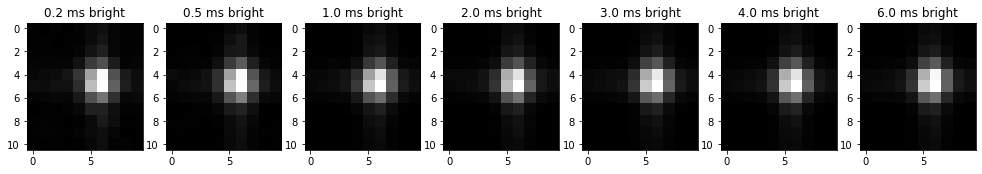

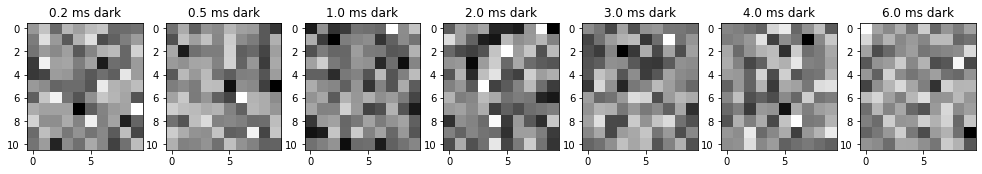

In [204]:
for ion_state in ['bright', 'dark']:
    fig, axes = plt.subplots(nrows=1, ncols=len(artificial_images[ion_state]), figsize=(17,4))
    for i, exposure_time_in_ms in enumerate(sorted(artificial_images[ion_state])):
        avg_image = np.mean(artificial_images[ion_state][exposure_time_in_ms], 0)
        axes[i].imshow(avg_image, cmap=plt.get_cmap('gray'))
        axes[i].set_title(f'{exposure_time_in_ms} ms {ion_state}')

failed to fit for row 0, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 1, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 2, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 3, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 7, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 0.2. assuming lambda = 0.
failed to fit for row 0, col 9, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 1, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 3, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 4, t_exp 0.2. assuming lambda = 0.
failed to fit for row 1, col 5, t_exp 0.

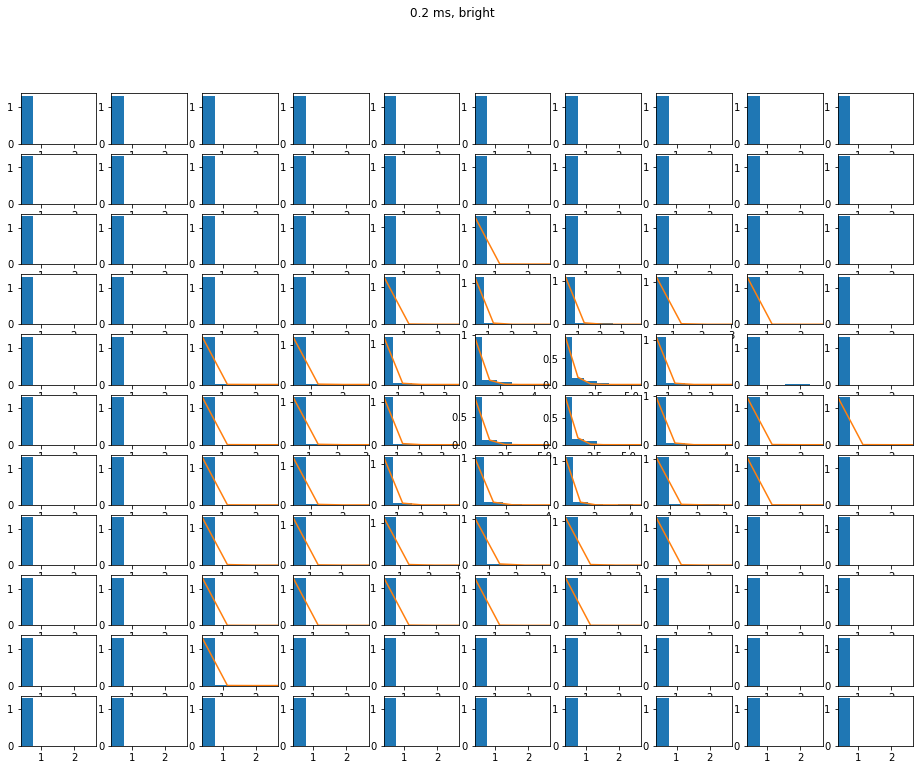

failed to fit for row 0, col 0, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 1, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 2, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 3, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 7, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 0.5. assuming lambda = 0.
failed to fit for row 0, col 9, t_exp 0.5. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 0.5. assuming lambda = 0.
failed to fit for row 1, col 1, t_exp 0.5. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 0.5. assuming lambda = 0.
failed to fit for row 1, col 3, t_exp 0.5. assuming lambda = 0.
failed to fit for row 1, col 4, t_exp 0.5. assuming lambda = 0.
failed to fit for row 1, col 5, t_exp 0.

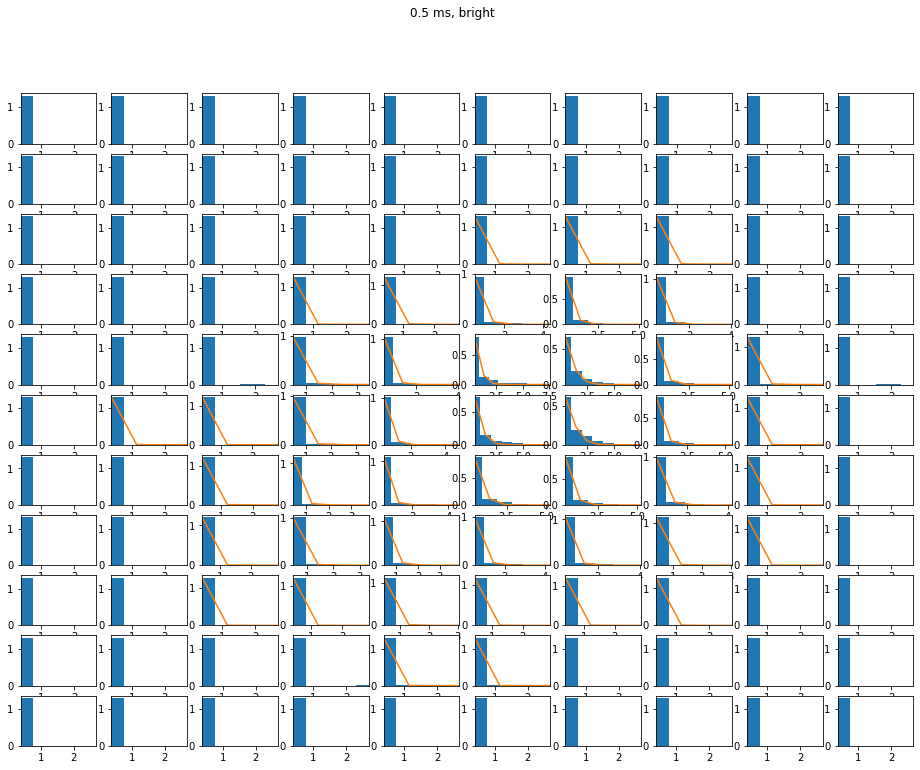

failed to fit for row 0, col 0, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 1, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 2, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 3, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 7, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 1.0. assuming lambda = 0.
failed to fit for row 0, col 9, t_exp 1.0. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 1.0. assuming lambda = 0.
failed to fit for row 1, col 1, t_exp 1.0. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 1.0. assuming lambda = 0.
failed to fit for row 1, col 3, t_exp 1.0. assuming lambda = 0.
failed to fit for row 1, col 4, t_exp 1.0. assuming lambda = 0.
failed to fit for row 1, col 5, t_exp 1.

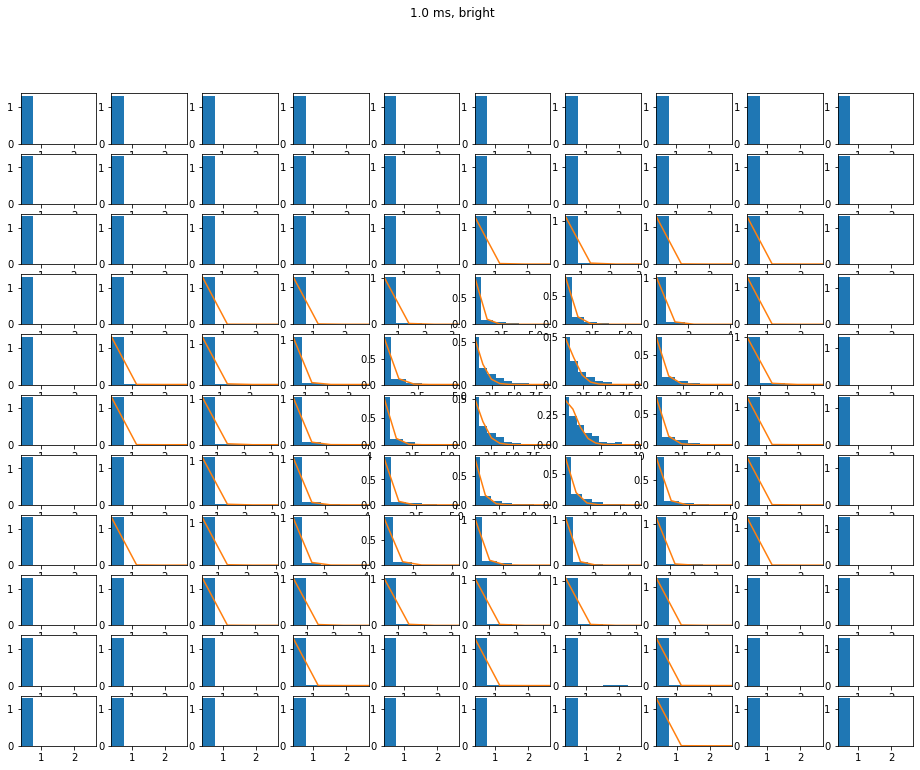

failed to fit for row 0, col 0, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 1, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 2, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 3, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 7, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 2.0. assuming lambda = 0.
failed to fit for row 0, col 9, t_exp 2.0. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 2.0. assuming lambda = 0.
failed to fit for row 1, col 1, t_exp 2.0. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 2.0. assuming lambda = 0.
failed to fit for row 1, col 3, t_exp 2.0. assuming lambda = 0.
failed to fit for row 1, col 4, t_exp 2.0. assuming lambda = 0.
failed to fit for row 1, col 5, t_exp 2.

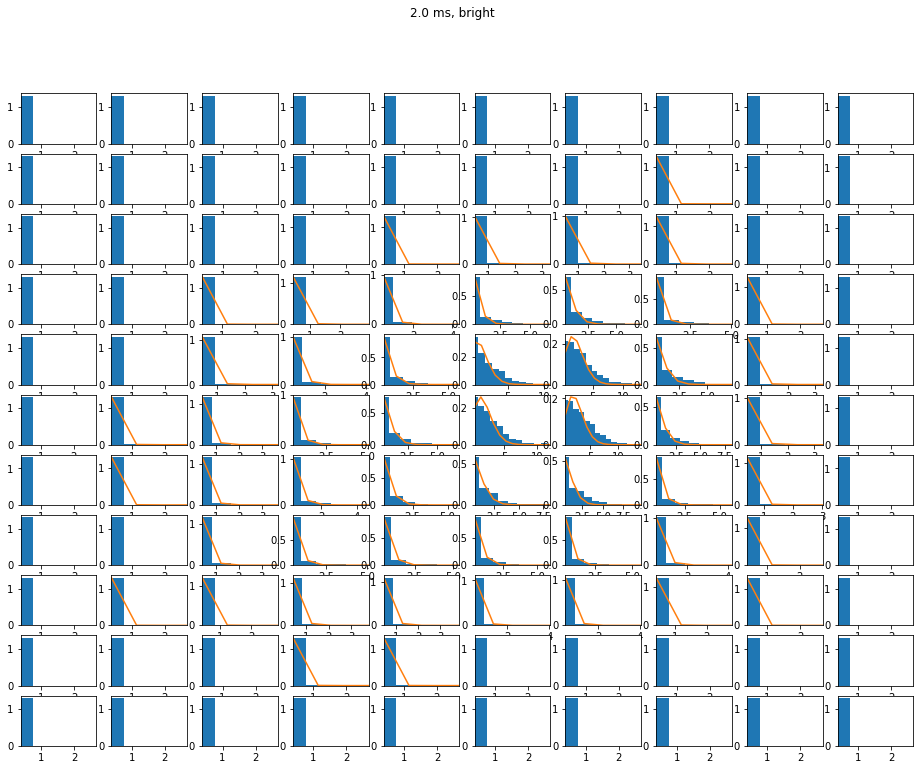

failed to fit for row 0, col 0, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 1, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 2, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 3, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 7, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 3.0. assuming lambda = 0.
failed to fit for row 0, col 9, t_exp 3.0. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 3.0. assuming lambda = 0.
failed to fit for row 1, col 1, t_exp 3.0. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 3.0. assuming lambda = 0.
failed to fit for row 1, col 3, t_exp 3.0. assuming lambda = 0.
failed to fit for row 1, col 4, t_exp 3.0. assuming lambda = 0.
failed to fit for row 1, col 6, t_exp 3.

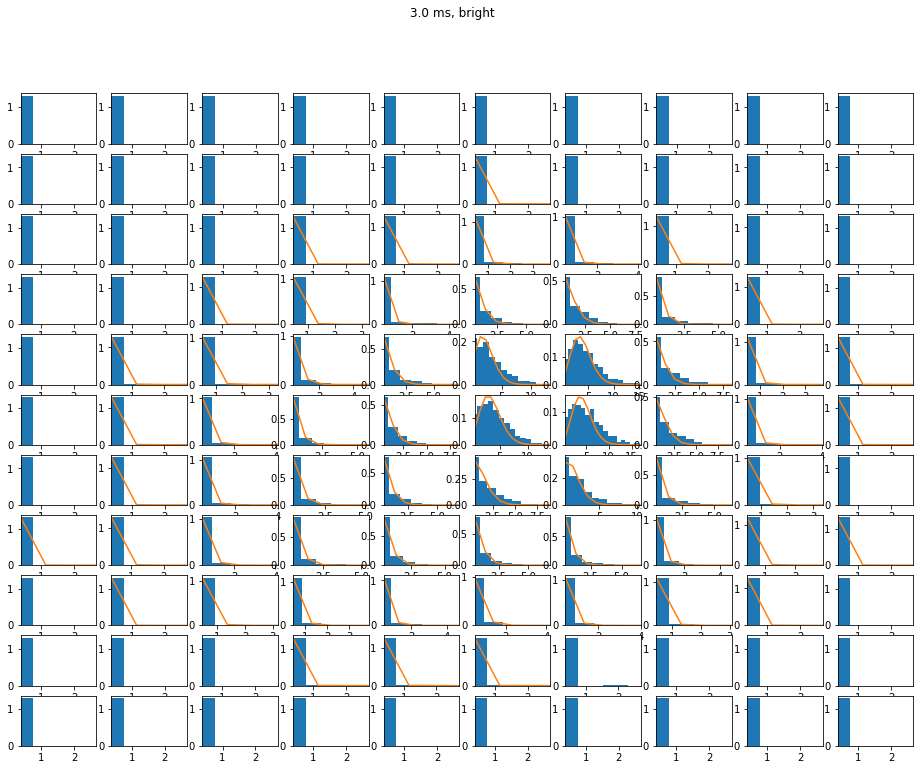

failed to fit for row 0, col 0, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 1, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 2, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 3, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 7, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 4.0. assuming lambda = 0.
failed to fit for row 0, col 9, t_exp 4.0. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 4.0. assuming lambda = 0.
failed to fit for row 1, col 1, t_exp 4.0. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 4.0. assuming lambda = 0.
failed to fit for row 1, col 3, t_exp 4.0. assuming lambda = 0.
failed to fit for row 1, col 4, t_exp 4.0. assuming lambda = 0.
failed to fit for row 1, col 5, t_exp 4.

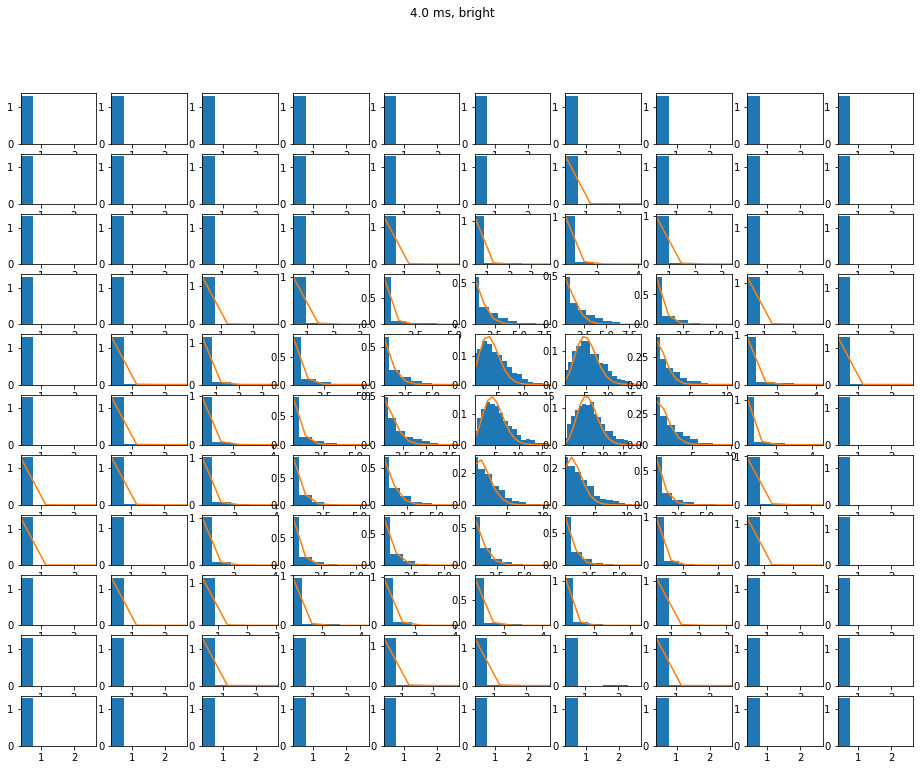

failed to fit for row 0, col 0, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 1, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 2, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 3, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 4, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 5, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 6, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 7, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 8, t_exp 6.0. assuming lambda = 0.
failed to fit for row 0, col 9, t_exp 6.0. assuming lambda = 0.
failed to fit for row 1, col 0, t_exp 6.0. assuming lambda = 0.
failed to fit for row 1, col 1, t_exp 6.0. assuming lambda = 0.
failed to fit for row 1, col 2, t_exp 6.0. assuming lambda = 0.
failed to fit for row 1, col 3, t_exp 6.0. assuming lambda = 0.
failed to fit for row 1, col 4, t_exp 6.0. assuming lambda = 0.
failed to fit for row 1, col 5, t_exp 6.

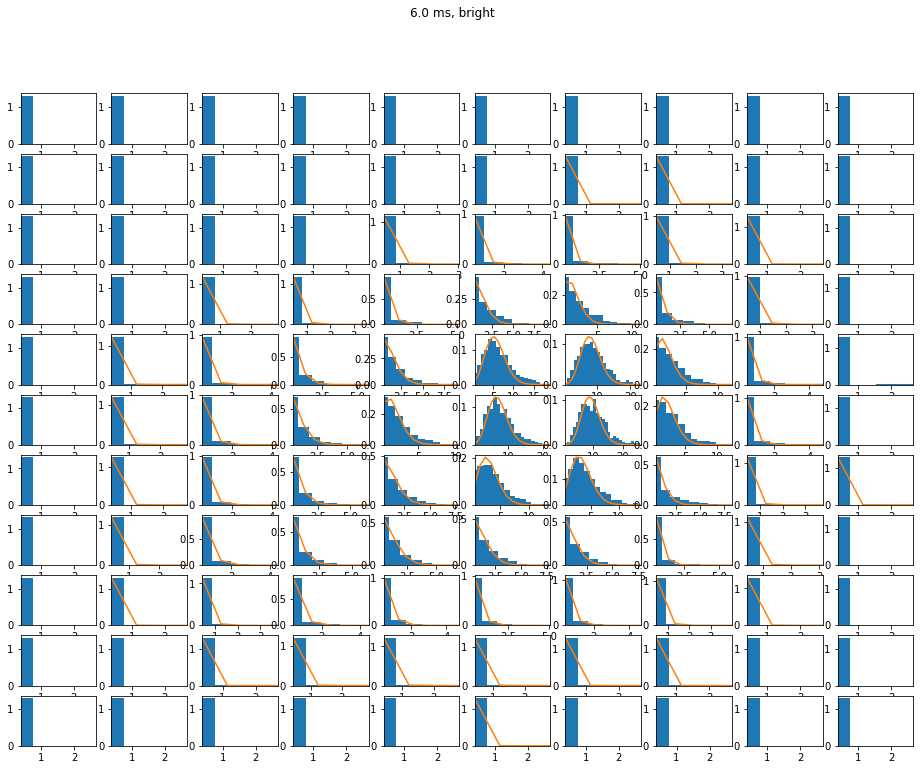

In [12]:
artificial_lambda_bright = defaultdict(list)

ion_state = 'bright'

exposure_times = [0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 6.0]
for exposure_time in exposure_times:
    fig, axes = plt.subplots(nrows=11, ncols=10, figsize=(16,12))
    for row in range(0, 11):
        lambda_row = []
        for col in range(0, 10):
            axis = axes[row][col]
            one_pixel = [image[row][col] for image in artificial_images[ion_state][exposure_time]]
            histogram_range = (0, np.percentile(one_pixel, q=98) * 1.1 + 3) #np.max(one_pixel) + 2)
            bin_count = int(histogram_range[1]) + 1
            y,x,_ = axis.hist(np.array(one_pixel).ravel(), bins=bin_count, range=histogram_range, density=True)
            x1 = [(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)]

            def poisson(x, A, lamb, b):
                '''A is amplitude, lamb is mean, b is horizontal scaling.'''
                bx = np.multiply(b, x)
                return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

            def scaled_poisson(x, A, lamb):
                return poisson(x, A, lamb, b=1.0)  # make the horizontal scaling constant

            guess = [1.0, np.mean(one_pixel)]
            if True:
                try:
                    popt, pcov = curve_fit(scaled_poisson, x1, y, p0=guess, bounds=((0, 0), (np.inf, np.inf)))
                    axis.plot(x1, scaled_poisson(x1, *popt))
                    lambda_row.append(popt[1])
                    #print(*popt)
                    #print(f'lambda={popt[1]} for row {row}, col {col}, t_exp {exposure_time}')
                except:
                    print(f'failed to fit for row {row}, col {col}, t_exp {exposure_time}. assuming lambda = 0.')
                    lambda_row.append(0)

            #x_fit = np.linspace(histogram_range[0], histogram_range[1], 8001)
            #axis.plot(x_fit, scaled_poisson(x_fit, *guess), 'k--', label='initial guess', lw=2)

            #axis.set_title(f'row {row}, col {col}')
            axis.set_xlim(min(x1), max(x1))

        artificial_lambda_bright[exposure_time].append(lambda_row)

    plt.suptitle(f'{exposure_time} ms, {ion_state}')
    plt.show()

## Plot the fitted $\lambda$ values for each pixel as a function of exposure time.

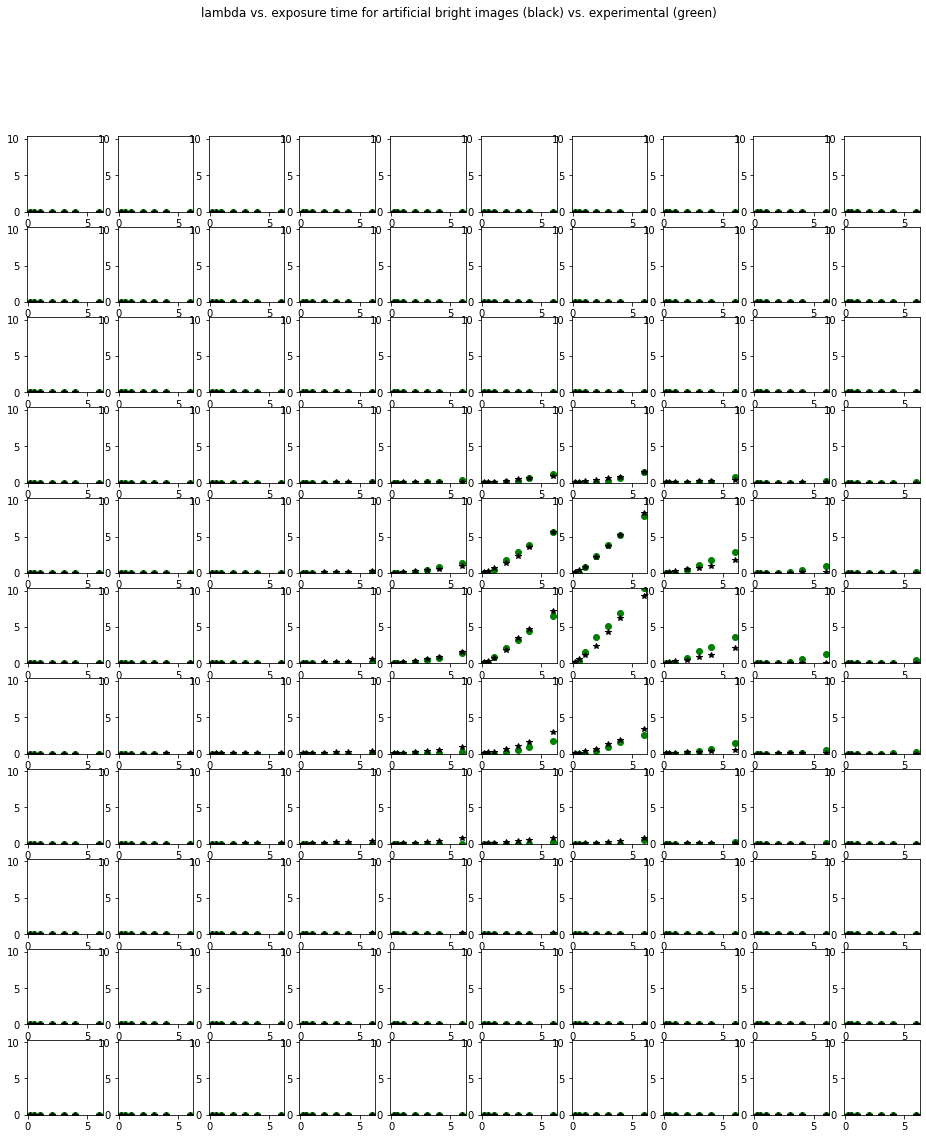

In [13]:
fig, axes = plt.subplots(nrows=11, ncols=10, figsize=(16,18))
for row in range(0, 11):
    for col in range(0, 10):
        axis = axes[row][col]
        lambda_values = [lambda_bright[t][row][col] for t in exposure_times]
        axis.plot(exposure_times, lambda_values, 'go')
        artificial_lambda_values = [artificial_lambda_bright[t][row][col] for t in exposure_times]
        axis.plot(exposure_times, artificial_lambda_values, 'k*')
        #axis.set_title(f'row {row}, col {col}')
        
        axis.set_ylim(0, max(np.max(lambda_bright[6]), np.max(artificial_lambda_bright[6])))

plt.suptitle(f'lambda vs. exposure time for artificial bright images (black) vs. experimental (green)')
plt.show()

# Run some simple detection algorithms

In [88]:
# average of whole image
def total_brightness(image):
    return np.sum(image)

# single pixel
def single_pixel_brightness(image):
    return image[5][6]

# average of fixed 2x2 pixel cluster
def fixed_cluster_brightness(image):
    return np.sum([row[4:7] for row in image[4:7]])

# average of brightest 2x2 pixel cluster
def max_cluster_brightness(image):
    image_avg = np.mean(image)
    max_cluster_avg = image_avg
    for i in range(len(image) - 1):
        for j in range(len(image[i]) - 1):
            max_cluster_avg = max(
                max_cluster_avg,
                np.mean([row[j:j+2] for row in image[i:i+2]])
            )
            
    return max_cluster_avg

In [219]:
algorithm = total_brightness
exposure_time = 0.5

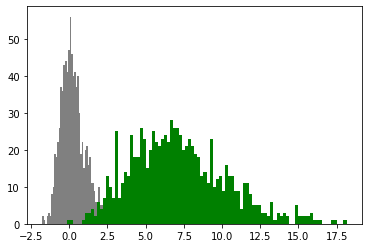

In [220]:
bright_metric = [algorithm(image) for image in experimental_images['bright'][exposure_time]]
dark_metric = [algorithm(image) for image in experimental_images['dark'][exposure_time]]

histogram_range = min(dark_metric), max(bright_metric)
plt.hist(dark_metric, color='grey', bins=200, range=histogram_range);
plt.hist(bright_metric, color='green', bins=100, range=histogram_range);

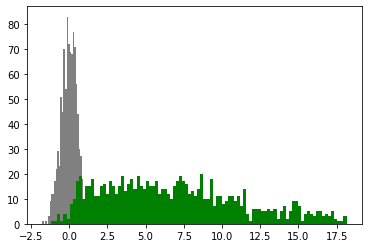

In [221]:
bright_metric = [algorithm(image) for image in artificial_images['bright'][exposure_time]]
dark_metric = [algorithm(image) for image in artificial_images['dark'][exposure_time]]

#histogram_range = min(dark_metric), max(bright_metric)
plt.hist(dark_metric, color='grey', bins=200, range=histogram_range);
plt.hist(bright_metric, color='green', bins=100, range=histogram_range);